In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *
plt.rcParams.update({'figure.figsize': (4,2.5), 'figure.dpi': 150, 'image.cmap': 'viridis'})

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_7_ss6_np15/')

In [4]:
data_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'], axis=1)

In [5]:
data_df['path'] = data_df.apply(lambda x: pathlib.Path(x.path), axis=1)

In [6]:
errors = compute_errors(data_path)

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
for k, df in errors.items():
    errors[k] = pd.merge(
        df, 
        data_df.loc[:, ['path', 'W_condition', 'W_smin', 'W_smax', 'x_condition',
           'x_smin', 'x_smax', 'cov_condition', 'cov_smin', 'cov_smax']],
        on='path', how='left'
    )

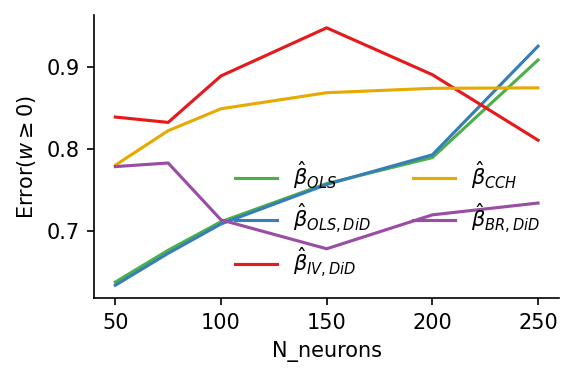

In [8]:
plot_errors(errors, 'n_neurons', 
            keys=['beta_ols', 
                  'beta_ols_did', 
                  'beta_iv_did', 
                  'naive_cch', 
                  'beta_brew_did'],
            legend_kws=dict(ncol=2),
#             ylim=[0.2,1.05],
            save='sweep_7_error_n_neurons')

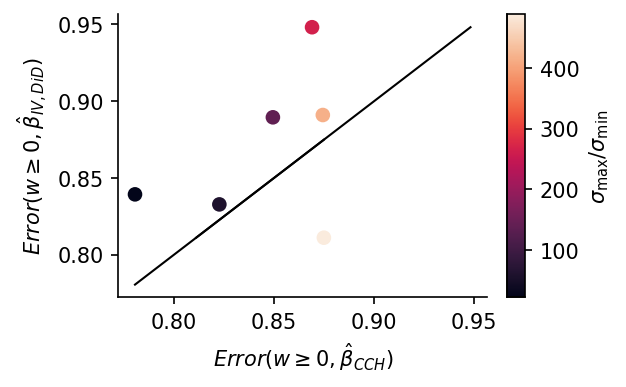

In [9]:
import matplotlib
mnorm = matplotlib.colors.LogNorm()
var1 = 'error_naive_cch'
var2 = 'error_beta_iv_did'

for target_weight in errors:
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(3.5,2.5), dpi=150)
    xmin, xmax = errors[target_weight].loc[:,[var1, var2]].min(), errors[target_weight].loc[:,[var1, var2]].max()
    sc = ax.scatter(
        errors[target_weight][var1], 
        errors[target_weight][var2], 
        c=errors[target_weight].cov_condition,
#         norm=mnorm,
        cmap='rocket'
    )
#     sc = ax.scatter(errors[target_weight][var1], errors[target_weight][var2], c=mnorm(errors[target_weight].cov_condition))
    ax.plot([xmin, xmax], [xmin, xmax], c='k', zorder=0, lw=1)
    lab1 = ",".join([labels[v] for v in var1.split("_")[2:]])
    lab2 = ",".join([labels[v] for v in var2.split("_")[2:]])
    elab = fr'$Error(w > 0, $' if target_weight=='weight>0' else fr'$Error(w = 0, $' if target_weight=='weight==0' else fr'$Error(w \geq 0, $'
    ax.set_xlabel(elab + fr'$\hat{{\beta}}_{{{lab1}}})$')
    ax.set_ylabel(elab + fr'$\hat{{\beta}}_{{{lab2}}})$')
    cbar = plt.colorbar(sc, cax=cax)
#     cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())
#     cbar.ax.set_ylabel(r'$||\mathrm{cov}|| \times ||\mathrm{cov}^{-1}||$')
    cbar.ax.set_ylabel(r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$')
    sns.despine()
    savefig(f'sweep_7_error_condition_{target_weight}')

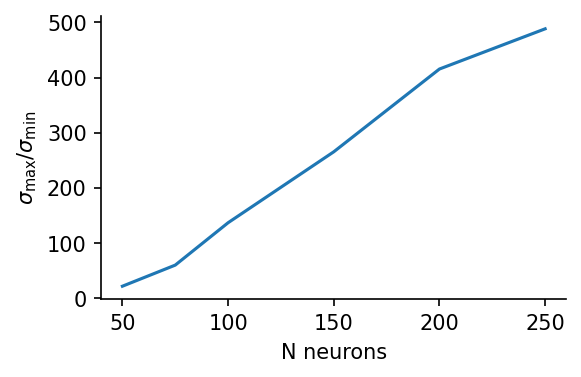

In [10]:
plt.figure()
sns.lineplot(
    data=data_df,
    x="n_neurons", y='cov_condition'
)
plt.ylabel(r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$')
plt.xlabel('N neurons')
# plt.ylim(0.5, 0.9)
# plt.margins(0.1)
sns.despine()
savefig(f'sweep_7_condition_n_neurons')

# Regression

In [11]:
samples = compute_all_samples(data_path)

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
index = int(errors['weight>=0'].query('n_neurons==200').index.values)
index

1

In [13]:
df = samples[index]

In [14]:
df.keys()

Index(['Unnamed: 0', 'source', 'target', 'pair', 'weight', 'source_stim',
       'source_stim_strength', 'target_stim', 'n_trials', 'yz_sum', 'z_sum',
       'yzinv_sum', 'zinv_sum', 'yx_sum', 'x_sum', 'yxinv_sum', 'xinv_sum',
       'xz_sum', 'xzinv_sum', 'y0z_sum', 'y0x_sum', 'y0zinv_sum', 'y0xinv_sum',
       'x0z_sum', 'x0zinv_sum', 'const', 'n_neurons', 'dt', 'ref_scale',
       'abs_ref_scale', 'spike_scale', 'abs_ref_strength', 'rel_ref_strength',
       'stim_scale', 'stim_strength', 'stim_period', 'stim_isi_min',
       'stim_isi_max', 'n_stim', 'alpha', 'sparsity', 'glorot_normal',
       'n_time_step', 'I0', 'r', 'n', 'NA', 'S', 'n_pos', 'depth', 'Imax', 'K',
       'n_hill', 'x1', 'x2', 'y1', 'y2', 'z1', 'z2', 'target_weight',
       'exclude_path_stem', 'beta_iv', 'beta_brew', 'beta_ols', 'beta_iv_did',
       'beta_brew_did', 'beta_ols_did', 'hit_rate', 'naive_cch'],
      dtype='object')

In [15]:
dff = df.groupby('source').sample(1)

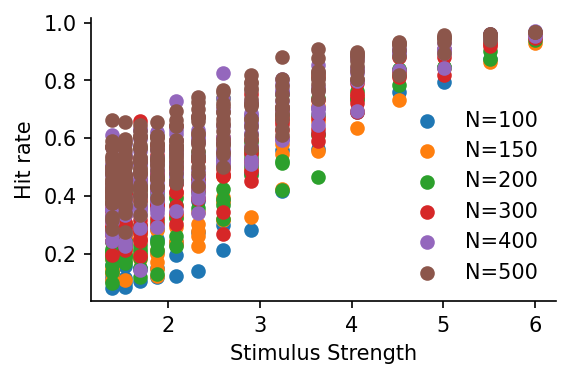

In [33]:
for i, (n_neurons, d) in enumerate(errors[list(errors.keys())[0]].groupby('n_neurons')):
    d = samples[int(d.index.values)].groupby('source').sample(1)
    plt.scatter(d.source_stim_strength, d.hit_rate, label=f'N={n_neurons*2:.0f}')
plt.legend(frameon=False)
plt.ylabel('Hit rate')
plt.xlabel('Stimulus Strength')
sns.despine()

<AxesSubplot:>

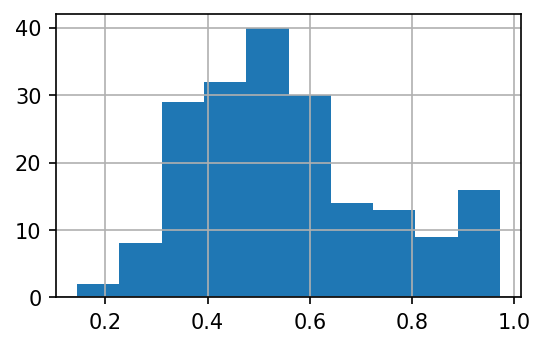

In [17]:
dff.hit_rate.hist()

<AxesSubplot:>

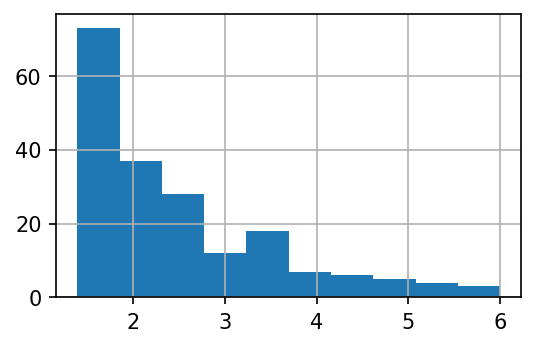

In [18]:
dff.source_stim_strength.hist()

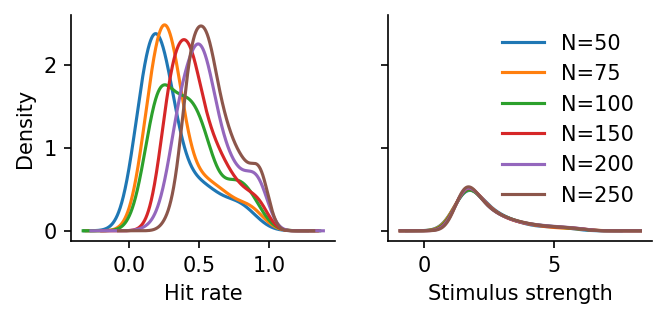

In [19]:
fig, axs = plt.subplots(1,2, figsize=(5,2), sharey=True)
for i, (n_neurons, dff) in enumerate(errors[list(errors.keys())[0]].groupby('n_neurons')):
    df = samples[int(dff.index.values)].groupby('source').sample(1)
#     df.hit_rate.hist(ax=axs[i])
    df.hit_rate.plot.density(label=f'N={n_neurons:.0f}', ax=axs[0])
    df.source_stim_strength.plot.density(label=f'N={n_neurons:.0f}', ax=axs[1])
plt.legend(frameon=False)
sns.despine()
axs[0].set_xlabel('Hit rate')
axs[1].set_xlabel('Stimulus strength')
savefig('sweep_7_hit_rate_distribution')

In [20]:
df.keys()

Index(['Unnamed: 0', 'source', 'target', 'pair', 'weight', 'source_stim',
       'source_stim_strength', 'target_stim', 'n_trials', 'yz_sum', 'z_sum',
       'yzinv_sum', 'zinv_sum', 'yx_sum', 'x_sum', 'yxinv_sum', 'xinv_sum',
       'xz_sum', 'xzinv_sum', 'y0z_sum', 'y0x_sum', 'y0zinv_sum', 'y0xinv_sum',
       'x0z_sum', 'x0zinv_sum', 'const', 'n_neurons', 'dt', 'ref_scale',
       'abs_ref_scale', 'spike_scale', 'abs_ref_strength', 'rel_ref_strength',
       'stim_scale', 'stim_strength', 'stim_period', 'stim_isi_min',
       'stim_isi_max', 'n_stim', 'alpha', 'sparsity', 'glorot_normal',
       'n_time_step', 'I0', 'r', 'n', 'NA', 'S', 'n_pos', 'depth', 'Imax', 'K',
       'n_hill', 'x1', 'x2', 'y1', 'y2', 'z1', 'z2', 'target_weight',
       'exclude_path_stem', 'beta_iv', 'beta_brew', 'beta_ols', 'beta_iv_did',
       'beta_brew_did', 'beta_ols_did', 'hit_rate', 'naive_cch'],
      dtype='object')

In [21]:
df['ww'] = df.hit_rate.round(3)

In [22]:
subsample = df.groupby('ww').sample(df.groupby('ww').count().source.min())

In [23]:
samples.keys()

dict_keys([0, 1, 2, 3, 4, 5])

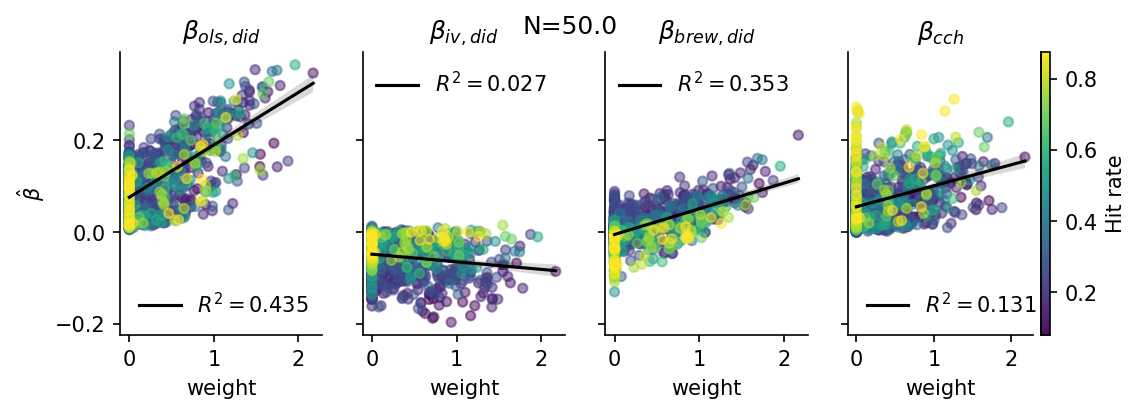

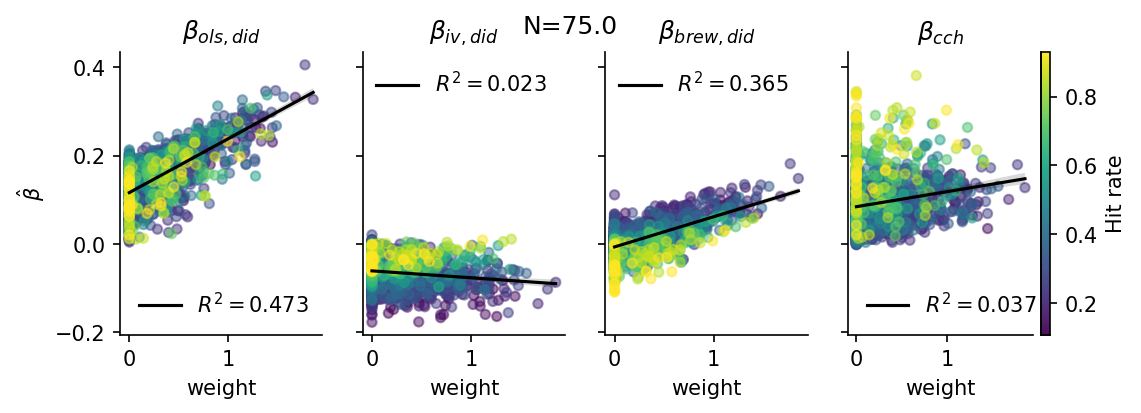

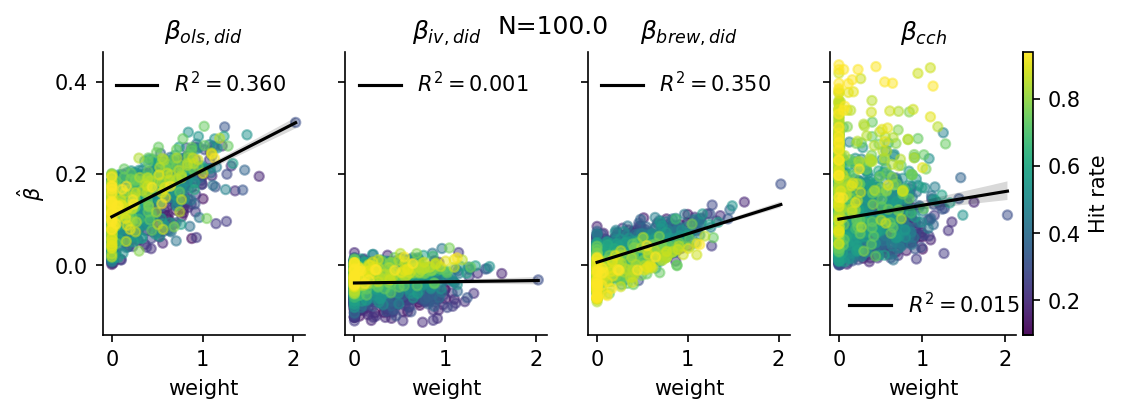

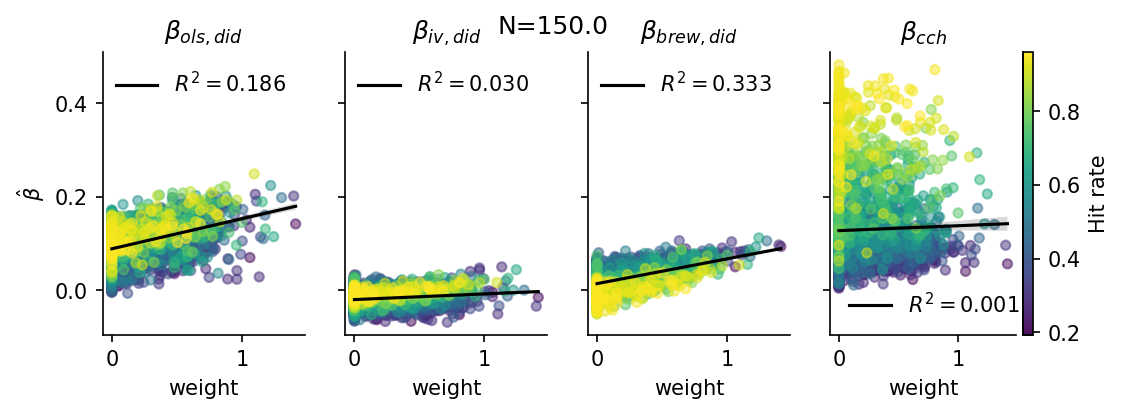

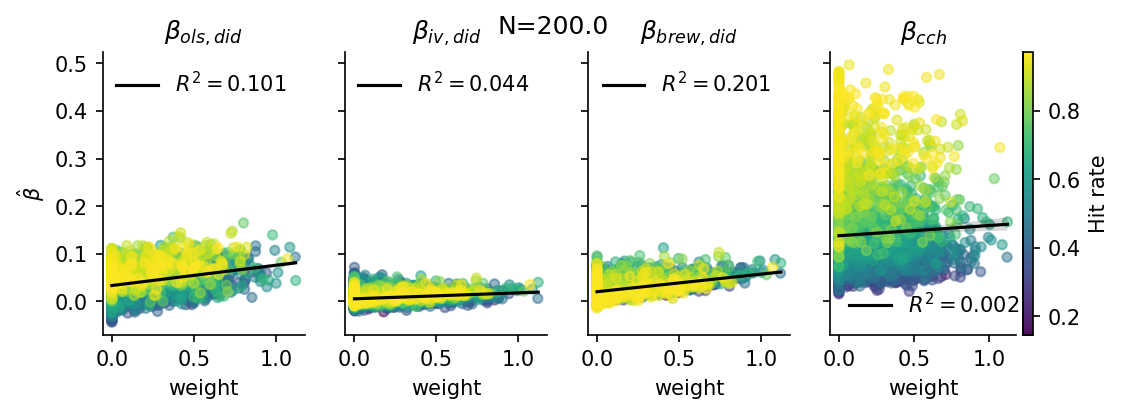

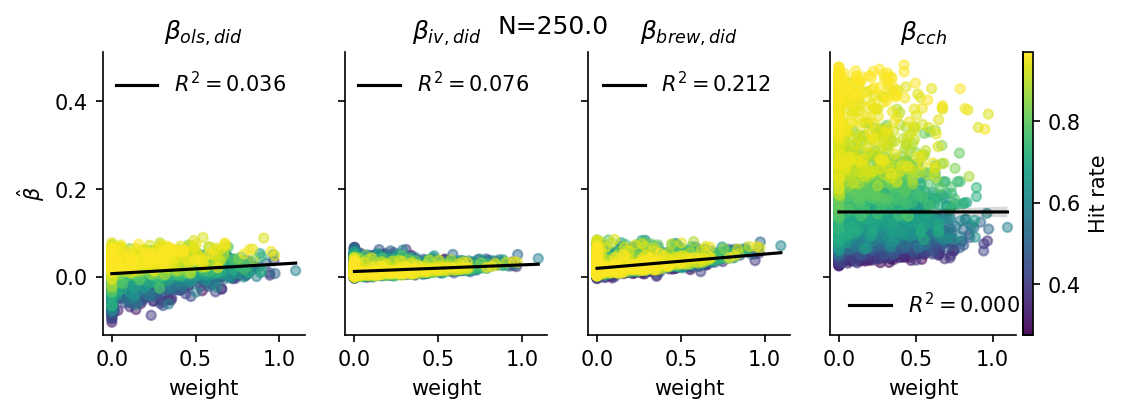

In [24]:
for i, (n_neurons, dff) in enumerate(errors[list(errors.keys())[0]].groupby('n_neurons')):
    df = samples[int(dff.index.values)]
    df['ww'] = df.hit_rate.round(3)
    subsample = df.groupby('ww').sample(25)
    plot_regression(
        subsample.query('weight>=0'), ['beta_ols_did','beta_iv_did', 'beta_brew_did', 'naive_cch'], 
        scatter_kws=dict(s=20, alpha=.5), clabel='Hit rate')
    plt.suptitle(f'N={n_neurons}')
    savefig(f'sweep_7_scatter_{n_neurons}')

# Classify

In [25]:
keys = ['beta_ols', 'beta_ols_did', 'beta_iv_did', 'beta_brew_did', 'naive_cch']

In [26]:
auroc = []
label = lambda x: ','.join([labels[l] for l in x.split('_')[1:]])
for index, df in samples.items():
    ser = df.iloc[0]
    for key in keys:
        a = roc_auc_score(df, key)
        score = {
            'n_neurons': ser.n_neurons,
            'group': label(key),
            'auroc': a
        }
        auroc.append(score)
auroc = pd.DataFrame(auroc)

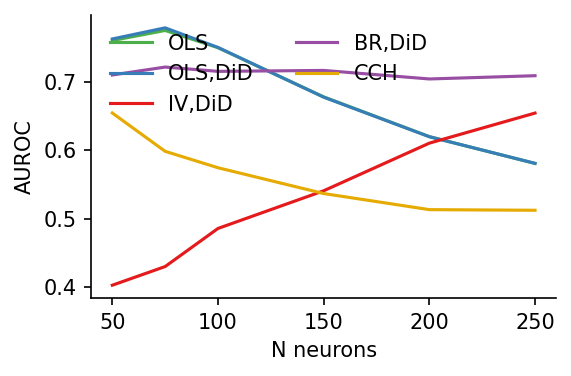

In [27]:
plt.figure()
sns.lineplot(
    data=auroc,#.sort_values('n_neurons'),
    x="n_neurons", y='auroc',
    hue="group",
    palette={label(key): colors[label(key).lower()] for key in keys}
)
plt.ylabel('AUROC')
plt.xlabel('N neurons')
# plt.ylim(0.5, 0.9)
# plt.margins(0.1)
sns.despine()
plt.legend(frameon=False, ncol=2, loc=2)
savefig(f'sweep_7_auroc_n_neurons')

# Convergence

In [28]:
error_convergence = compute_error_convergence(data_path)

  0%|          | 0/960 [00:00<?, ?it/s]

In [29]:
error_convergence_trials = compute_error_convergence_trials(data_path, n_samples=100)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [30]:
errors['weight>=0'].loc[index]

path                   /home/users/bjornmik/datasets/sweep_7_ss6_np15...
const                                                                5.0
n_neurons                                                          150.0
dt                                                                 0.001
ref_scale                                                           10.0
abs_ref_scale                                                        3.0
spike_scale                                                          5.0
abs_ref_strength                                                  -100.0
rel_ref_strength                                                   -30.0
stim_scale                                                           2.0
stim_strength                                                        6.0
stim_period                                                         50.0
stim_isi_min                                                        10.0
stim_isi_max                                       

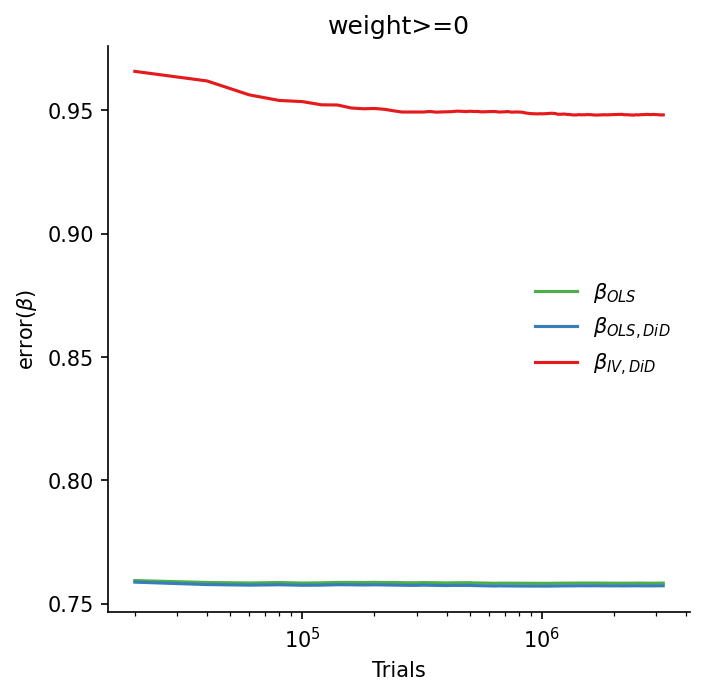

In [31]:
plot_error_convergence(error_convergence, index, ['beta_ols', 'beta_ols_did', 'beta_iv_did'])

IndexError: index 5 is out of bounds for axis 0 with size 5

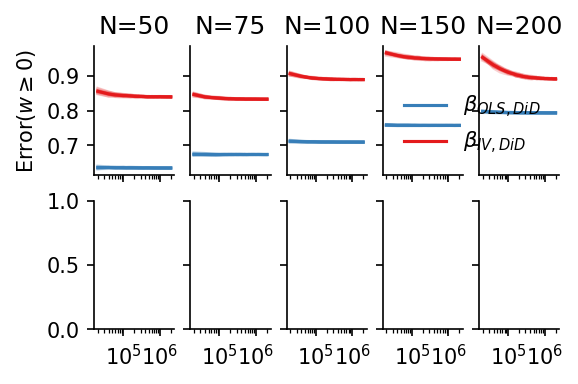

In [32]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey='row')
for i, (n_neurons, df) in enumerate(errors['weight>=0'].groupby('n_neurons')):
    index = int(df.index.values)
    plot_error_convergence_trials( 
        error_convergence_trials, 
        index, 
        keys=['beta_ols_did','beta_iv_did'], 
        axs=axs.T[i], legend=i==4, xlabels=(False,True), ylabels=[i==0]*2)
    axs[0,i].set_title(f'N={n_neurons:.0f}')

# Error difference

In [ ]:
error_trials = compute_error_trials(data_path, n_samples=100)

In [ ]:
errors = compute_error_confidence(errors, error_trials)

In [ ]:
plot_error_difference(errors, 'n_stim')

In [ ]:
import re

paths = [path for path in data_path.iterdir() if path.is_dir()]
paths = sorted(paths, key=lambda x: [int(i) for i in re.findall('\\d+', x.stem)])
data_df = pd.DataFrame({'path': paths})

iterator = tqdm(data_df.iterrows(), total=len(data_df))
for i, row in iterator:
    print(row.path)